In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge,Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
train_file_path = 'solar.csv'
test_file_path='solar_locations.csv'
df = pd.read_csv(train_file_path)
df

,lat,long,PVOUT_csi (kWh/kWp),DNI (kWh/m2),GHI (kWh/m2),DIF (kWh/m2),GTI_opta (kWh/m2),OPTA (°),TEMP (°C),ELE (m)
0,24.0,78.5,1622.837891,1522.078125,1895.203125,867.210938,2065.250000,27,24.5625,538
1,19.0,79.0,1590.478760,1432.570312,1928.570312,915.898438,2054.421875,23,28.0000,211
2,24.0,83.5,1574.196045,1396.468750,1858.812500,900.812500,2006.187500,25,24.9375,370
3,20.0,72.0,1686.185547,1591.343750,1990.789062,885.601562,2125.109375,22,26.6875,-29
4,18.0,76.0,1572.047729,1344.031250,1913.234375,961.898438,2020.531250,21,27.2500,528
...,...,...,...,...,...,...,...,...,...,...
811,18.5,76.5,1587.521118,1381.250000,1922.078125,949.210938,2035.781250,22,26.1250,613
812,30.5,77.5,1523.960938,1352.671875,1731.195312,863.093750,1931.968750,30,22.8750,427
813,10.5,76.0,1574.551025,1314.781250,1939.054688,949.000000,1988.507812,14,27.1250,-11
814,10.5,76.5,1438.100342,1142.421875,1787.445312,920.578125,1833.875000,16,26.1875,291


In [15]:
df.describe()

,lat,long,PVOUT_csi (kWh/kWp),DNI (kWh/m2),GHI (kWh/m2),DIF (kWh/m2),GTI_opta (kWh/m2),OPTA (°),TEMP (°C),ELE (m)
count,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000
mean,22.750000,78.122549,1587.967469,1441.713503,1869.822515,877.083305,2016.629375,24.682598,23.312500,635.360294
std,5.729163,3.533146,82.221885,188.175532,111.509306,81.797973,116.642082,4.430346,9.048958,1161.950160
min,10.000000,72.000000,1234.851074,519.968750,927.609375,492.265625,1002.476562,11.000000,-19.875000,-2396.000000
25%,19.000000,75.500000,1538.255737,1312.833984,1805.023438,863.574219,1945.527344,22.000000,24.750000,189.750000
50%,22.750000,77.500000,1588.827881,1439.191406,1895.214844,895.980469,2034.515625,25.000000,25.750000,336.000000
75%,26.500000,80.500000,1618.749481,1518.160156,1940.935547,926.806641,2068.955078,27.000000,26.750000,550.500000
max,35.500000,85.500000,1970.455933,2395.867188,2050.710938,978.109375,2320.390625,38.000000,29.250000,6168.000000


In [16]:
nan_counts = df.isna().sum()
print("Count of NaN values in each column:")
print(nan_counts)

Count of NaN values in each column:
lat                    0
long                   0
PVOUT_csi (kWh/kWp)    0
DNI (kWh/m2)           0
GHI (kWh/m2)           0
DIF (kWh/m2)           0
GTI_opta (kWh/m2)      0
OPTA (°)               0
TEMP (°C)              0
ELE (m)                0
dtype: int64


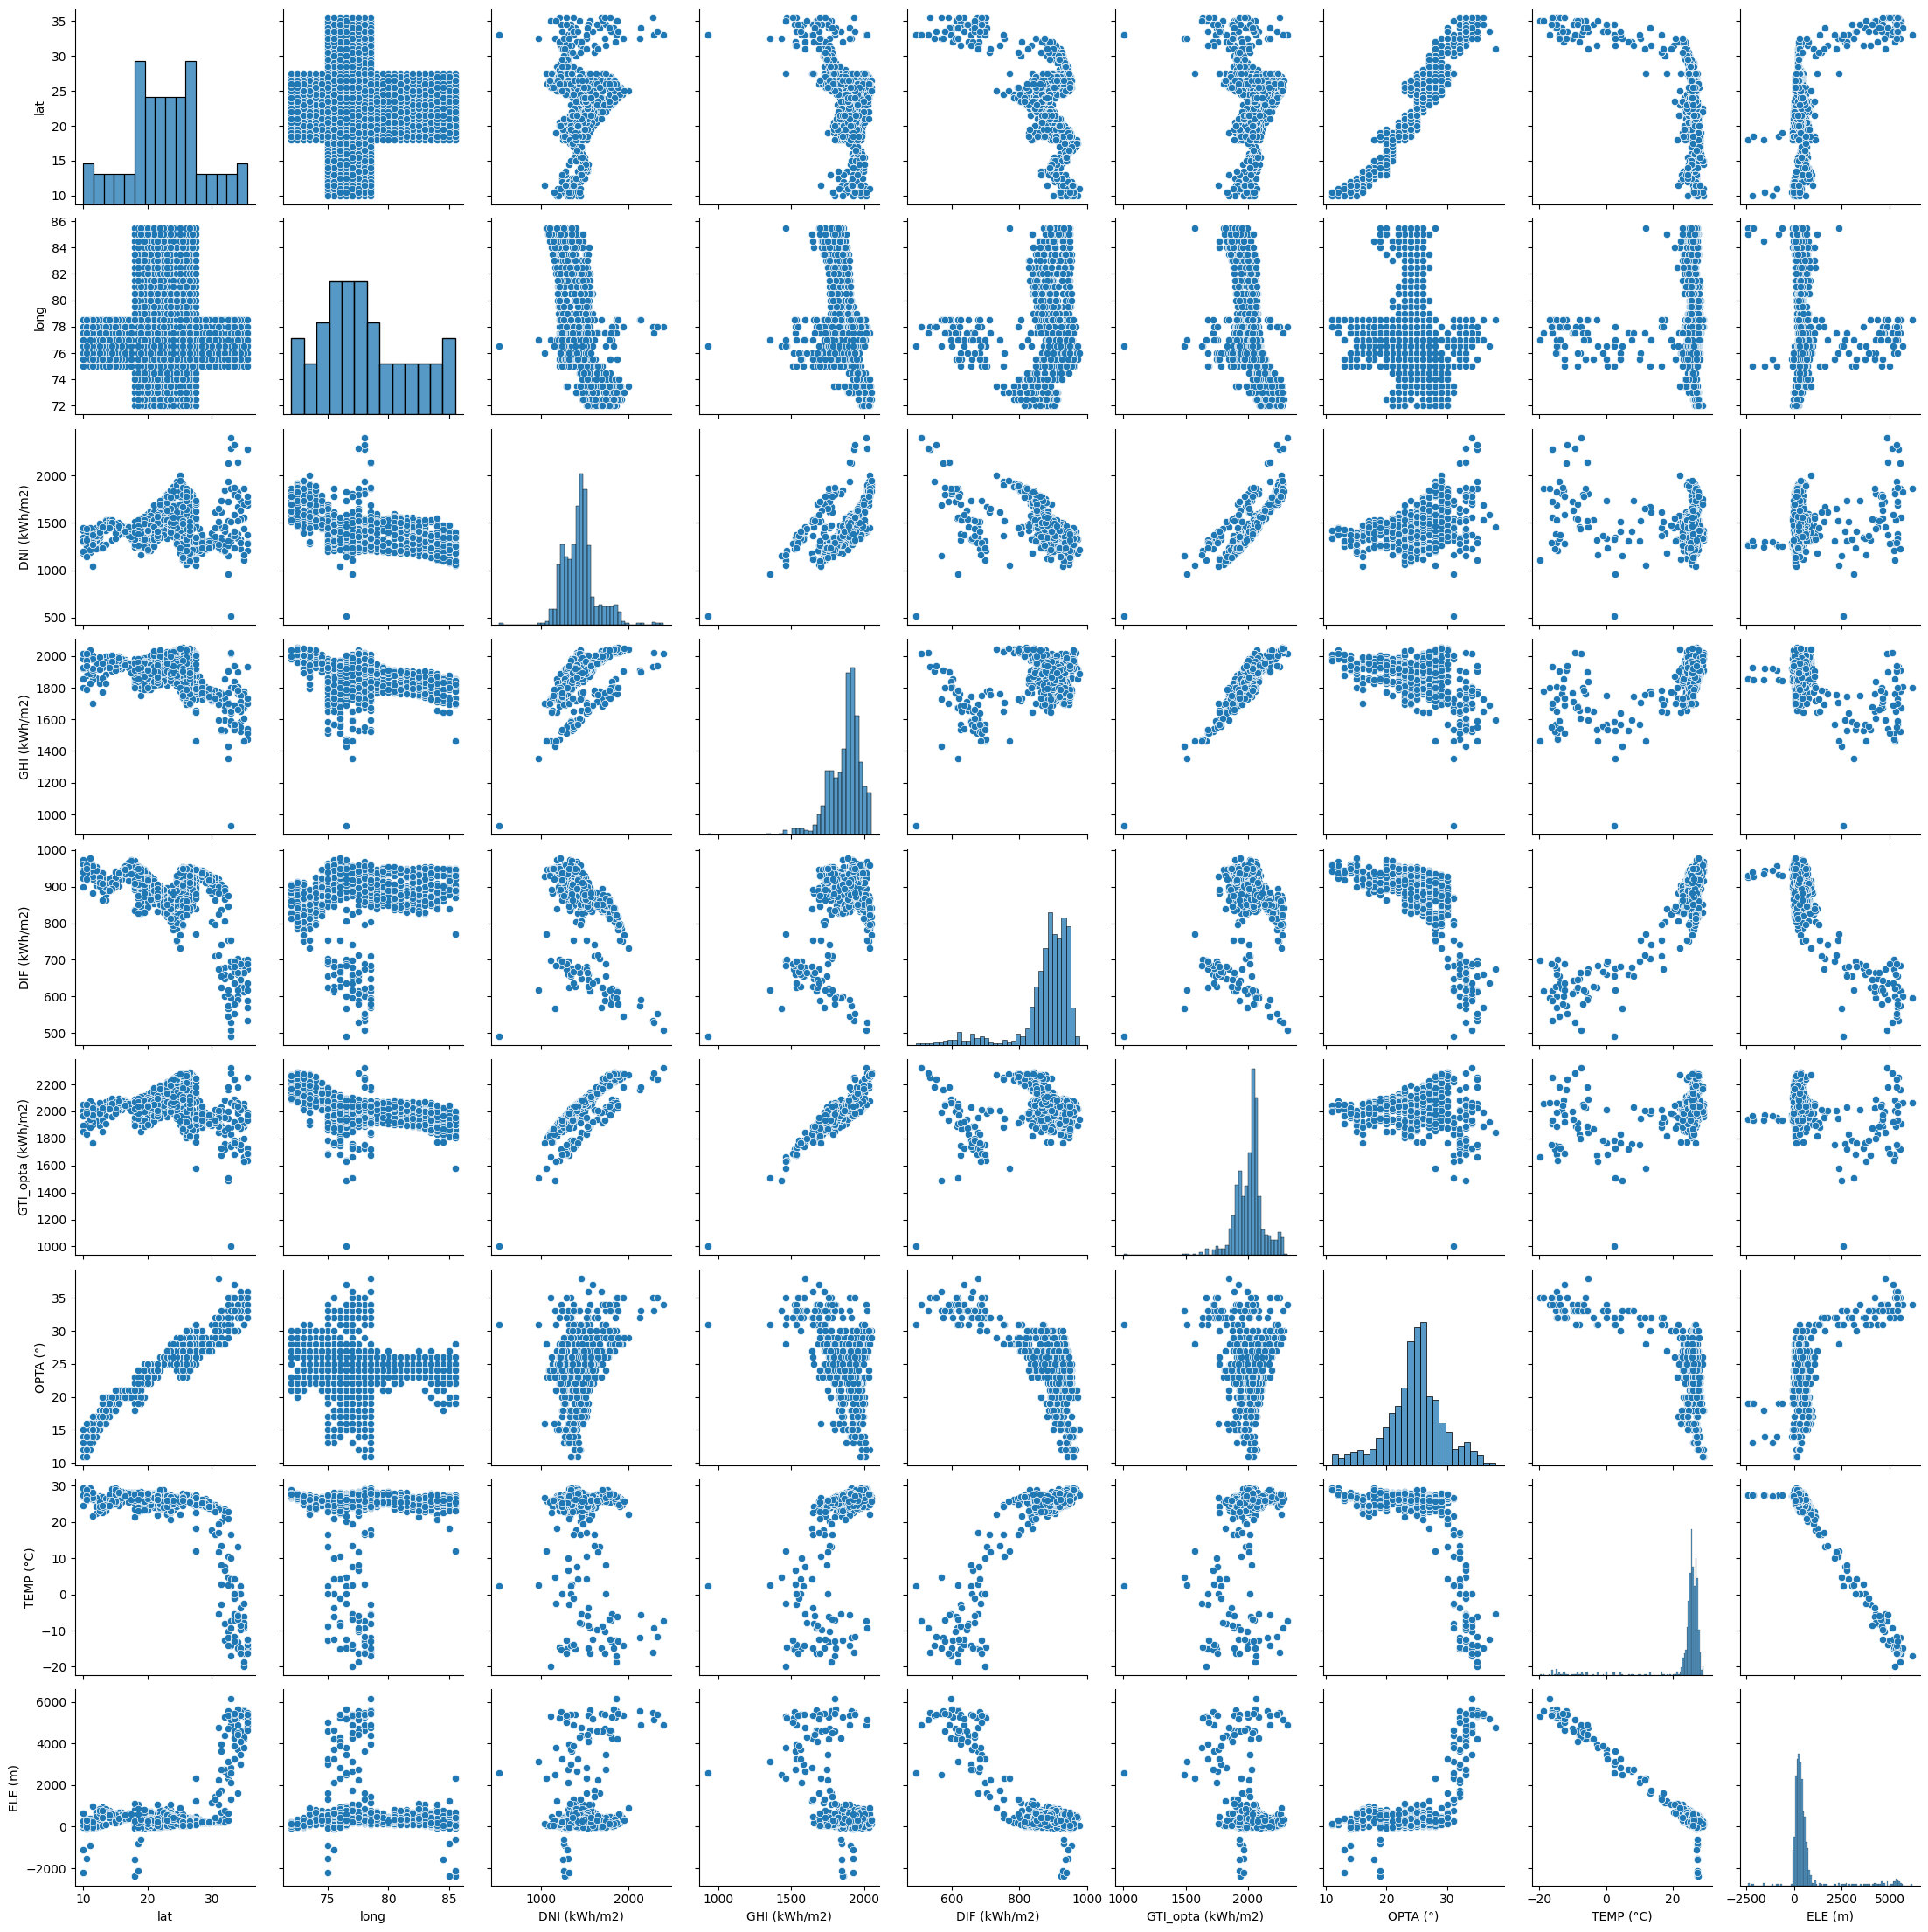

In [5]:
features=df
features=features.drop(columns='PVOUT_csi (kWh/kWp)')
sns.pairplot(features)


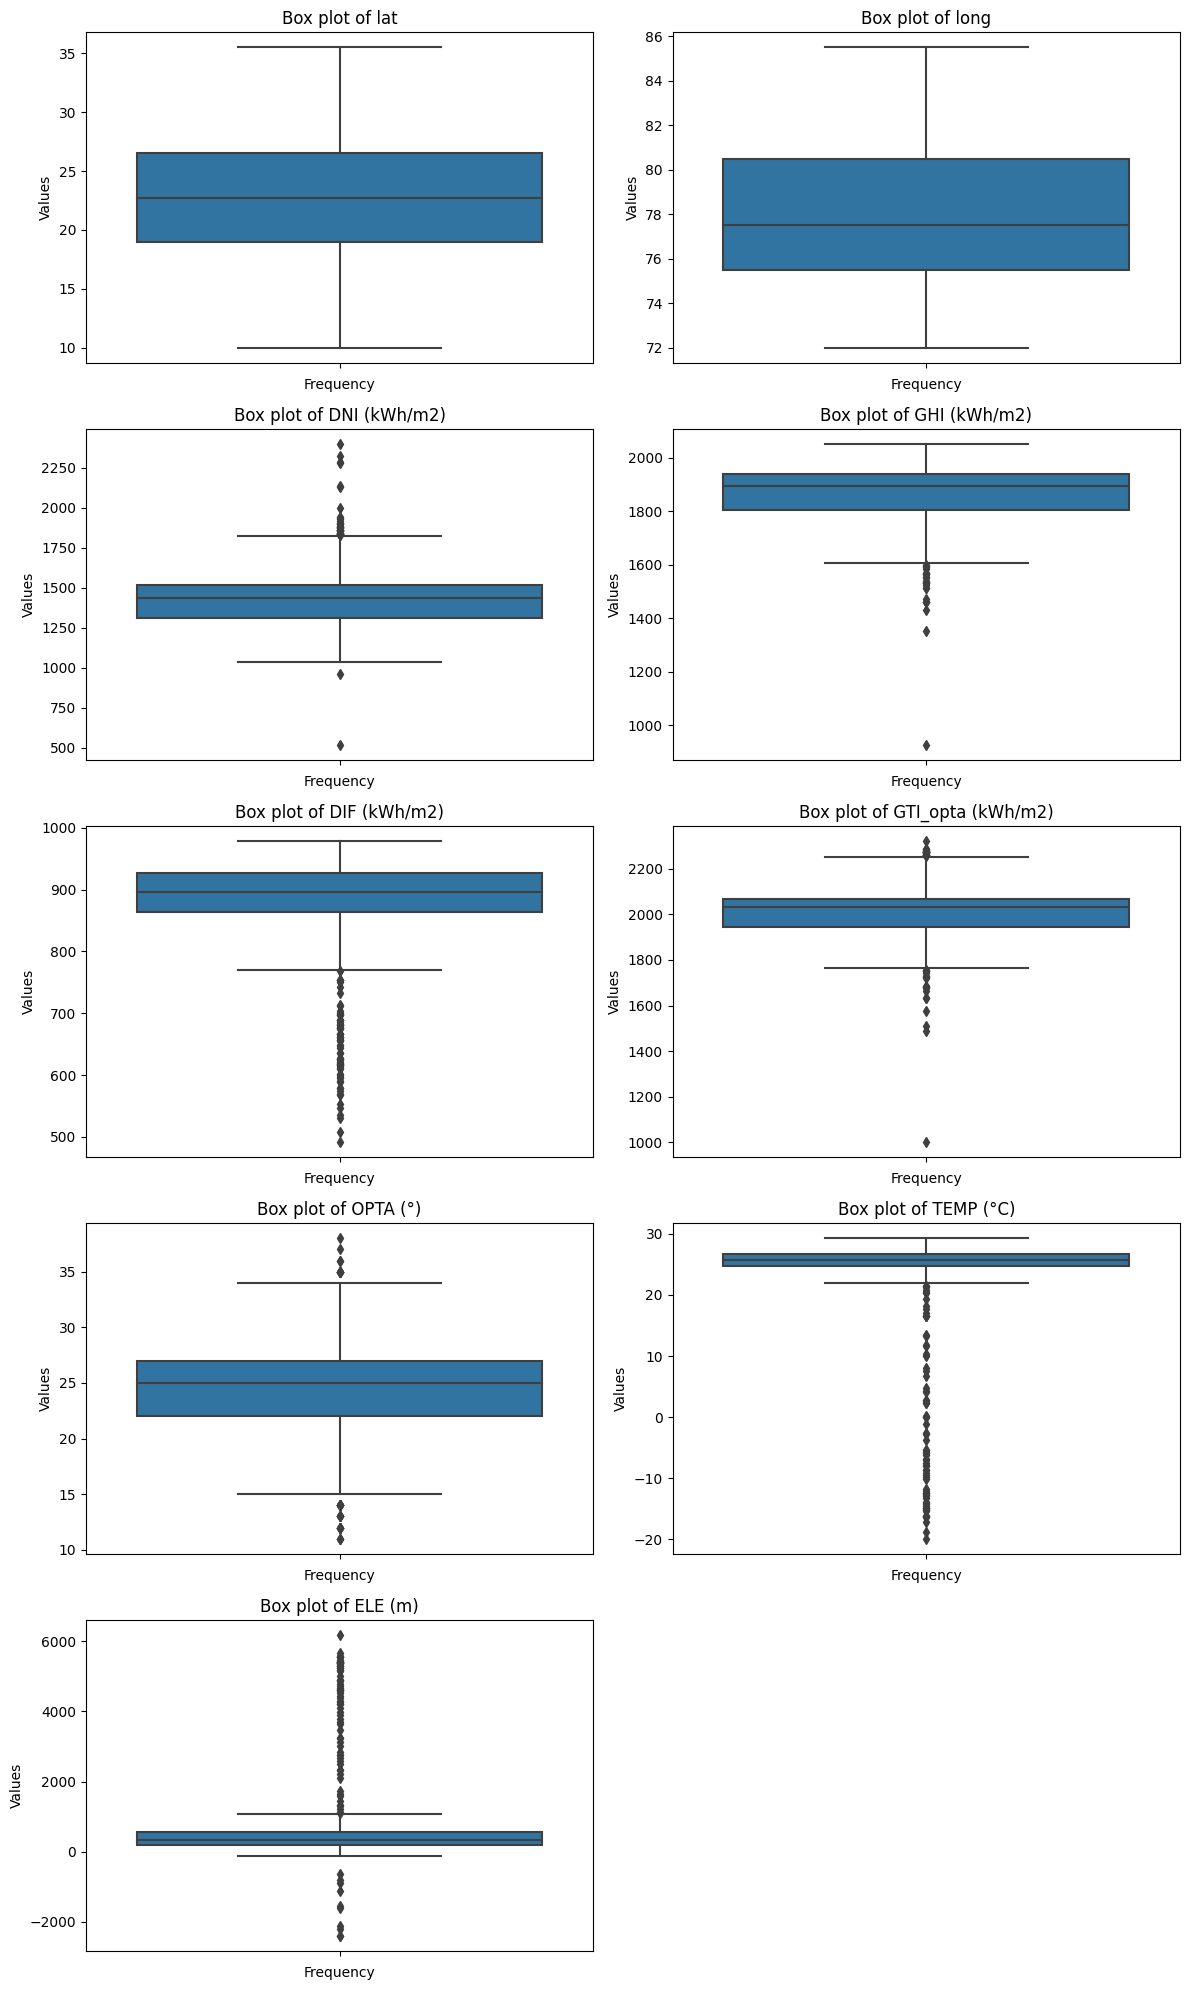

In [12]:
num_cols = len(features.columns)
num_rows = ((num_cols+1) //2) 
fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 4))
for i, column in enumerate(features.columns):
    row = i // 2
    col = i % 2
    sns.boxplot(ax=axes[row, col],y=df[column])
    axes[row, col].set_title(f'Box plot of {column}')
    axes[row, col].set_xlabel('Frequency')
    axes[row, col].set_ylabel('Values')
if num_cols % 2 != 0:
    fig.delaxes(axes[num_rows - 1, 1])
plt.tight_layout()
plt.show()

In [3]:
from geopy.geocoders import Photon
import folium
map=folium.Map()
loc=[]
x=np.array(df['lat'])
y=np.array(df['long'])
z=np.array(df['PVOUT_csi (kWh/kWp)'])

geolocator = Photon(user_agent="geoapiexercises")

for i in range(len(df)):
    lat=x[i]
    long=y[i]
    map.add_child(folium.Marker(location=[lat,long],popup=str(z[i]),icon=folium.Icon(color='green')))
    location = geolocator.geocode(str(lat)+","+str(long))
    loc.append(location)
map


In [ ]:
df=df.sample(frac=1)
ratio=0.75
data_size=df.shape[0]
train_size=int(data_size*ratio)
validate_size=data_size-train_size
print(train_size)
print(validate_size)


612
204


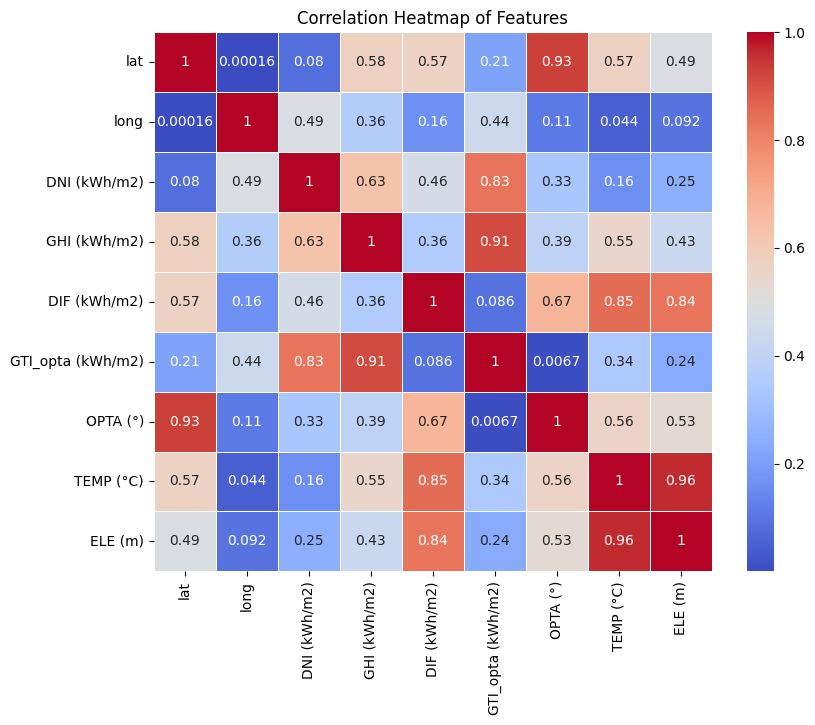

In [ ]:
train=df[0:train_size]
x_train=train.drop(columns='PVOUT_csi (kWh/kWp)')
corr = x_train.corr()
# Generate a heatmap
plt.figure(figsize=(9, 7))
heatmap = sns.heatmap(abs(corr), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap of Features')
plt.show()

In [ ]:
y=df['PVOUT_csi (kWh/kWp)']
mean=y.mean()
std_dev=y.std()

In [ ]:
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
scaled_df

,lat,long,PVOUT_csi (kWh/kWp),DNI (kWh/m2),GHI (kWh/m2),DIF (kWh/m2),GTI_opta (kWh/m2),OPTA (°),TEMP (°C),ELE (m)
0,-1.091579,-0.034707,0.147261,-0.047081,0.786061,0.708289,0.369575,-0.831731,0.456133,-0.207847
1,-1.615537,-0.176311,0.038260,0.236239,0.828684,0.273071,0.184333,-1.509294,0.165867,0.097861
2,0.567621,0.673312,-0.856281,-1.137823,-0.631310,0.875151,-0.680821,0.071687,0.269533,-0.444664
3,0.480295,-0.884329,1.228554,1.187688,0.892830,-0.186039,1.353488,0.749250,0.297178,-0.239710
4,-1.877516,-0.884329,-0.085284,-0.666481,0.494637,0.786655,-0.255114,-1.961003,0.407755,-0.580725
...,...,...,...,...,...,...,...,...,...,...
811,0.567621,-1.733951,1.941903,1.787313,1.474556,-0.204962,2.108998,1.200959,0.476866,-0.434330
812,-2.226821,-0.884329,-0.265770,-0.685590,0.506484,0.768019,-0.407650,-2.638567,0.435400,-2.435642
813,0.567621,0.531708,-0.855453,-1.111194,-0.642737,0.852501,-0.665943,0.071687,0.283355,-0.439497
814,0.480295,0.814916,-0.826282,-1.058726,-0.581395,0.820295,-0.635985,0.071687,0.304089,-0.459303


In [ ]:
features=scaled_df.drop(columns=['PVOUT_csi (kWh/kWp)'])
y=scaled_df['PVOUT_csi (kWh/kWp)']
n_features=features.shape[1]
features

,lat,long,DNI (kWh/m2),GHI (kWh/m2),DIF (kWh/m2),GTI_opta (kWh/m2),OPTA (°),TEMP (°C),ELE (m)
0,-1.091579,-0.034707,-0.047081,0.786061,0.708289,0.369575,-0.831731,0.456133,-0.207847
1,-1.615537,-0.176311,0.236239,0.828684,0.273071,0.184333,-1.509294,0.165867,0.097861
2,0.567621,0.673312,-1.137823,-0.631310,0.875151,-0.680821,0.071687,0.269533,-0.444664
3,0.480295,-0.884329,1.187688,0.892830,-0.186039,1.353488,0.749250,0.297178,-0.239710
4,-1.877516,-0.884329,-0.666481,0.494637,0.786655,-0.255114,-1.961003,0.407755,-0.580725
...,...,...,...,...,...,...,...,...,...
811,0.567621,-1.733951,1.787313,1.474556,-0.204962,2.108998,1.200959,0.476866,-0.434330
812,-2.226821,-0.884329,-0.685590,0.506484,0.768019,-0.407650,-2.638567,0.435400,-2.435642
813,0.567621,0.531708,-1.111194,-0.642737,0.852501,-0.665943,0.071687,0.283355,-0.439497
814,0.480295,0.814916,-1.058726,-0.581395,0.820295,-0.635985,0.071687,0.304089,-0.459303


In [ ]:
variance_captured=[]
components=[]
for i in range(1,n_features+1,1):
    pca = PCA(n_components=i)
    pca.fit_transform(features)
    variance_captured.append(sum(pca.explained_variance_ratio_))
    components.append(i)

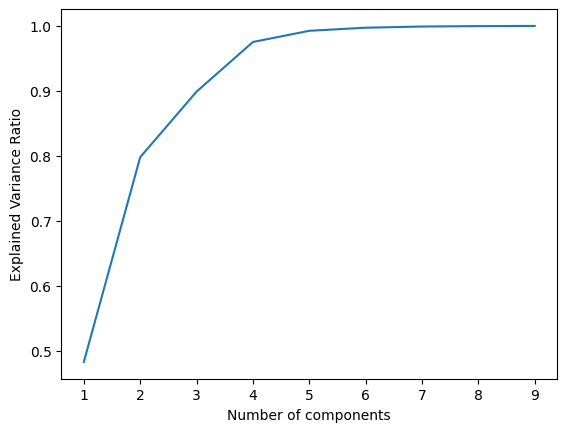

In [ ]:
plt.plot(components,variance_captured)
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [ ]:
pca = PCA(n_components=4)
reduced_features=pca.fit_transform(features)

In [ ]:
print(pca.components_)

[[ 0.39547111 -0.00621045  0.0808488  -0.31891886 -0.42049086 -0.17237372
   0.39301861 -0.44303644  0.42195744]
 [ 0.00832978  0.38038592 -0.56956225 -0.43004278  0.19153743 -0.53261134
  -0.12882971  0.03535607 -0.08769631]
 [-0.56927048 -0.07203742  0.02348447  0.0608578  -0.21178698 -0.17331499
  -0.53775136 -0.35632411  0.41886911]
 [ 0.05811579 -0.92142025 -0.23827206 -0.17124955  0.12304052 -0.2026382
  -0.01965004  0.02793771 -0.06433845]]


In [ ]:
print(sum(pca.explained_variance_ratio_))

0.975261083830196


In [ ]:
transformed_df=pd.DataFrame(reduced_features)
transformed_df['PVOUT_csi (kWh/kWp)']=y
transformed_df

,0,1,2,3,PVOUT_csi (kWh/kWp)
0,-1.664174,-0.253188,0.654249,-0.100135,0.147261
1,-1.654957,-0.425596,1.692091,-0.105392,0.038260
2,-0.199864,1.749924,-0.824970,0.072177,-0.856281
3,-0.086699,-2.214316,-0.931873,0.118705,1.228554
4,-2.431853,0.419391,1.690572,1.015598,-0.085284
...,...,...,...,...,...
811,-0.290405,-3.569255,-1.386285,0.517387,1.941903
812,-3.602426,0.750881,1.497620,1.159867,-0.265770
813,-0.190172,1.673581,-0.815382,0.192518,-0.855453
814,-0.250951,1.704664,-0.795162,-0.104696,-0.826282


In [ ]:
train_data=transformed_df[0:train_size]
validate_data=transformed_df[train_size:]
train_data

,0,1,2,3,PVOUT_csi (kWh/kWp)
0,-1.664174,-0.253188,0.654249,-0.100135,0.147261
1,-1.654957,-0.425596,1.692091,-0.105392,0.038260
2,-0.199864,1.749924,-0.824970,0.072177,-0.856281
3,-0.086699,-2.214316,-0.931873,0.118705,1.228554
4,-2.431853,0.419391,1.690572,1.015598,-0.085284
...,...,...,...,...,...
607,-2.701292,0.293023,2.200656,-0.140490,-0.238932
608,-0.648212,-0.046010,-0.097524,-0.896909,0.144369
609,-0.698153,-0.178058,-0.116594,-0.643573,0.078445
610,-0.985330,-0.612494,-0.148627,0.575871,0.158624


In [ ]:
X_train = train_data.drop(columns='PVOUT_csi (kWh/kWp)')
y_train = train_data['PVOUT_csi (kWh/kWp)']
X_validate = validate_data.drop(columns='PVOUT_csi (kWh/kWp)')
y_validate = validate_data['PVOUT_csi (kWh/kWp)']

X_train

,0,1,2,3
0,-1.664174,-0.253188,0.654249,-0.100135
1,-1.654957,-0.425596,1.692091,-0.105392
2,-0.199864,1.749924,-0.824970,0.072177
3,-0.086699,-2.214316,-0.931873,0.118705
4,-2.431853,0.419391,1.690572,1.015598
...,...,...,...,...
607,-2.701292,0.293023,2.200656,-0.140490
608,-0.648212,-0.046010,-0.097524,-0.896909
609,-0.698153,-0.178058,-0.116594,-0.643573
610,-0.985330,-0.612494,-0.148627,0.575871


c:\Python311\Lib\site-packages\statsmodels\stats\stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


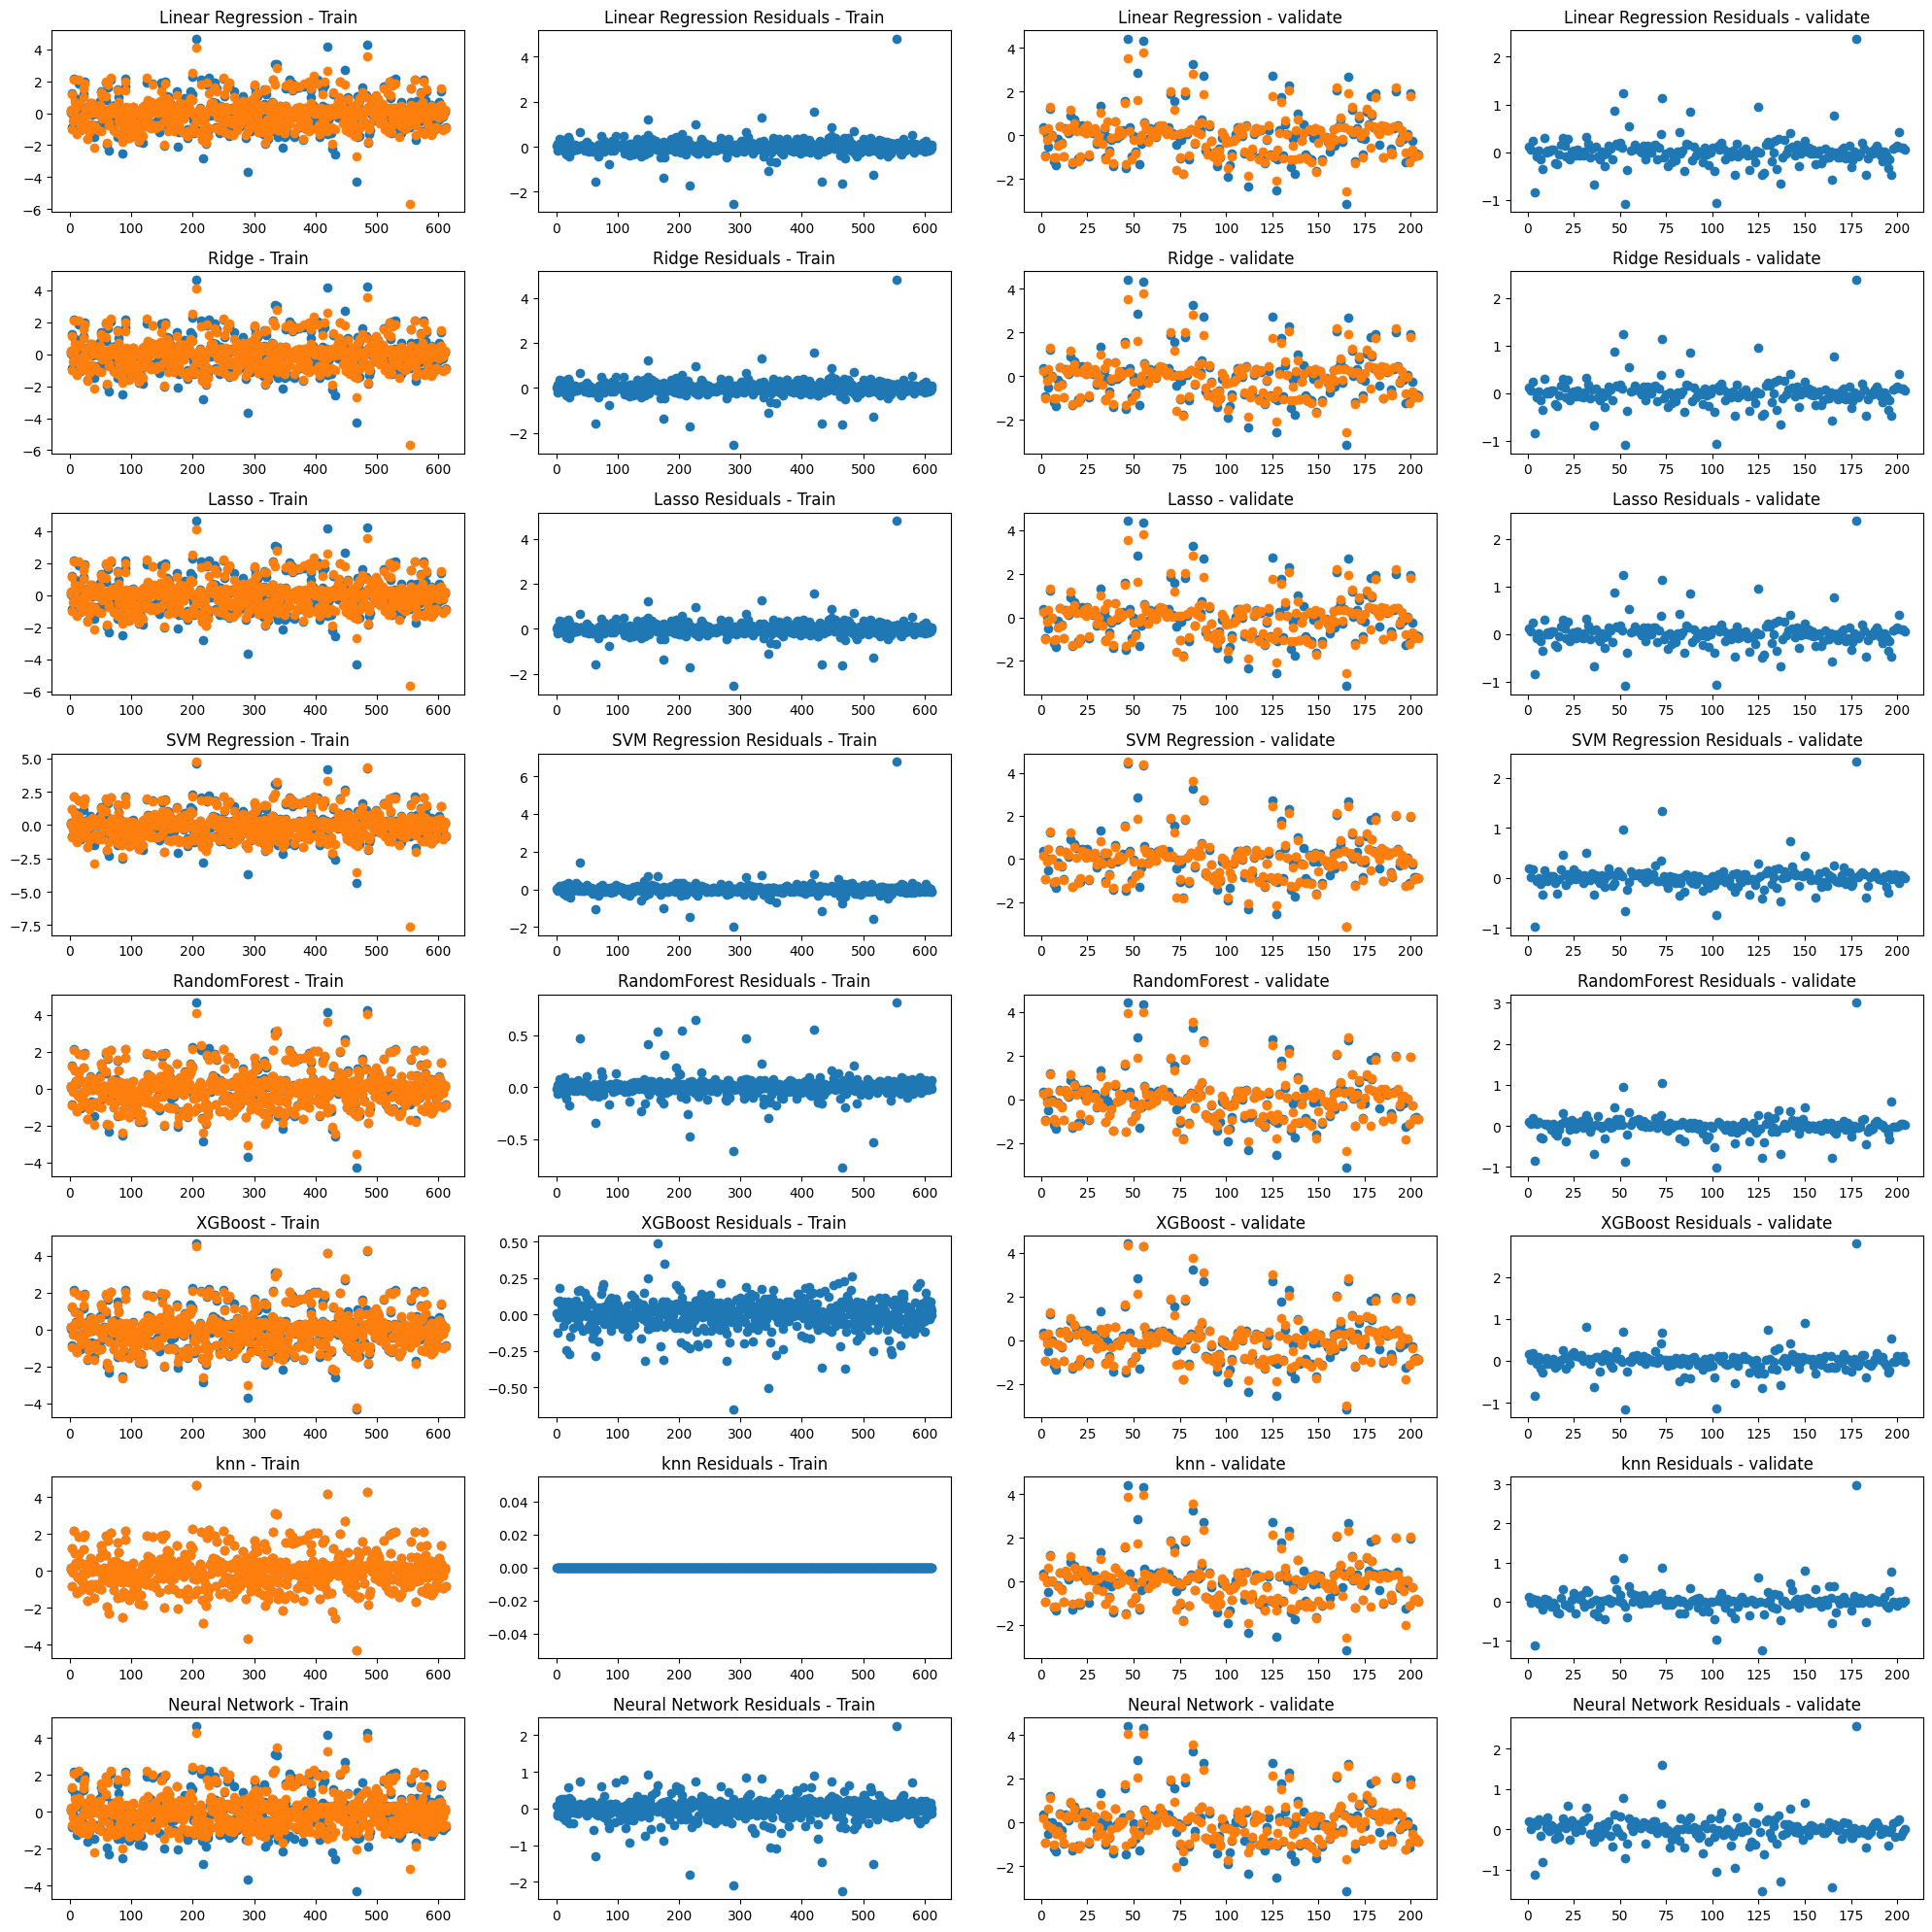

<Figure size 640x480 with 0 Axes>

In [ ]:
 
poly=PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train)
X_validate_poly=poly.transform(X_validate)

algorithms = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=0.001),
    'Lasso': Lasso(alpha=0.0001),
    'SVM Regression': SVR(kernel='poly',degree=2), 
    'RandomForest': RandomForestRegressor(),
    'XGBoost': GradientBoostingRegressor(),
    'knn': KNeighborsRegressor(weights='distance',n_neighbors=7),
    'Neural Network': MLPRegressor(hidden_layer_sizes=[10,10], max_iter=2000)
}

# Metric tables
metric_table_train = pd.DataFrame()
metric_table_validate=pd.DataFrame()


# Create a grid of subplots 
fig, axs = plt.subplots(len(algorithms),4,figsize=(20,20))
fig_row = -1
x_train=np.linspace(1,train_size,train_size)
x_validate=np.linspace(1,validate_size,validate_size)


# Run the algorithms ... create metrics and plots 
for algorithm_name, algorithm in algorithms.items():
    
    # Train model
    algorithm.fit(X_train_poly, y_train)

    # Train predictions
    y_train_pred = algorithm.predict(X_train_poly)
    
    # validate predictions
    y_validate_pred = algorithm.predict(X_validate_poly)
    
    # Train metrics
    r2_train = algorithm.score(X_train_poly, y_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    
    # validate metrics
    r2_validate = algorithm.score(X_validate_poly, y_validate)
    mse_validate = mean_squared_error(y_validate, y_validate_pred)

    # Additional metrics using statsmodels for all algorithms
    residuals_train = y_train - y_train_pred
    residuals_validate = y_validate - y_validate_pred
    
    durbin_watson_stat_train = sm.stats.durbin_watson(residuals_train)
    jb_stat_train, jb_p_value_train, _, _ = sm.stats.jarque_bera(residuals_train)
    
    durbin_watson_stat_validate = sm.stats.durbin_watson(residuals_validate)
    jb_stat_validate, jb_p_value_validate, _, _ = sm.stats.jarque_bera(residuals_validate)
    
    # Update metric tables
    metric_table_train.at[algorithm_name, 'R-squared'] = r2_train
    metric_table_train.at[algorithm_name, 'MSE'] = mse_train
    metric_table_train.at[algorithm_name, 'Durbin-Watson'] = durbin_watson_stat_train
    metric_table_train.at[algorithm_name, 'Jarque-Bera'] = jb_stat_train
    metric_table_train.at[algorithm_name, 'JB P-value'] = jb_p_value_train

    metric_table_validate.at[algorithm_name, 'R-squared'] = r2_validate
    metric_table_validate.at[algorithm_name, 'MSE'] = mse_validate
    metric_table_validate.at[algorithm_name, 'Durbin-Watson'] = durbin_watson_stat_validate
    metric_table_validate.at[algorithm_name, 'Jarque-Bera'] = jb_stat_validate
    metric_table_validate.at[algorithm_name, 'JB P-value'] = jb_p_value_validate
    
    fig_row = fig_row+1
    
    axs[fig_row, 0].scatter(x_train, y_train)
    axs[fig_row, 0].scatter(x_train, y_train_pred)
    axs[fig_row, 0].set_title(algorithm_name + " - Train")
    
    axs[fig_row, 1].scatter(x_train, residuals_train)
    axs[fig_row, 1].set_title(algorithm_name + " Residuals - Train")
    
    axs[fig_row, 2].scatter(x_validate, y_validate)
    axs[fig_row, 2].scatter(x_validate, y_validate_pred)
    axs[fig_row, 2].set_title(algorithm_name + " - validate")
    
    axs[fig_row, 3].scatter(x_validate, residuals_validate)
    axs[fig_row, 3].set_title(algorithm_name + " Residuals - validate")
    

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

In [ ]:
# Display metrics in tables
print("Metrics - Train Data:\n")
print(metric_table_train.to_string())
print("-------------------------------------------------")


print("Metrics - Validate Data:\n")
print(metric_table_validate.to_string())

Metrics - Train Data:

                   R-squared       MSE  Durbin-Watson   Jarque-Bera     JB P-value
Linear Regression   0.876989  0.118002       1.992595  1.272601e+05   0.000000e+00
Ridge               0.876989  0.118002       1.992594  1.272594e+05   0.000000e+00
Lasso               0.876989  0.118002       1.992552  1.271665e+05   0.000000e+00
SVM Regression      0.874401  0.120484       1.971504  1.435184e+06   0.000000e+00
RandomForest        0.989688  0.009892       1.966712  1.698302e+04   0.000000e+00
XGBoost             0.989432  0.010137       2.073724  7.344597e+02  3.266642e-160
knn                 1.000000  0.000000            NaN           NaN            NaN
Neural Network      0.897024  0.098783       2.021423  5.814183e+03   0.000000e+00
-------------------------------------------------
Metrics - Validate Data:

                   R-squared       MSE  Durbin-Watson   Jarque-Bera  JB P-value
Linear Regression   0.904961  0.106618       2.092270   2131.995381       

100%|██████████| 204/204 [00:00<00:00, 275.10it/s]


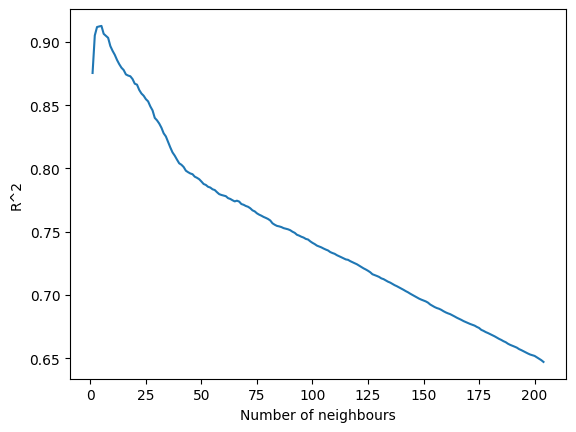

Max R^2 = 0.9126509894606897
Number of neighbours for max R^2 =  5


In [ ]:
r2=[]
for i in tqdm(range(1,validate_size+1)):
    model=KNeighborsRegressor(weights='distance',n_neighbors=i)
    model.fit(X_train_poly, y_train)
    y_validate_pred = algorithm.predict(X_validate_poly)
    r2.append(model.score(X_validate_poly, y_validate))
plt.plot(x_validate,r2)
plt.xlabel('Number of neighbours')
plt.ylabel('R^2')
plt.show()
print("Max R^2 =",max(r2))
print("Number of neighbours for max R^2 = ",r2.index(max(r2))+1)

100%|██████████| 1000/1000 [00:00<00:00, 1993.06it/s]


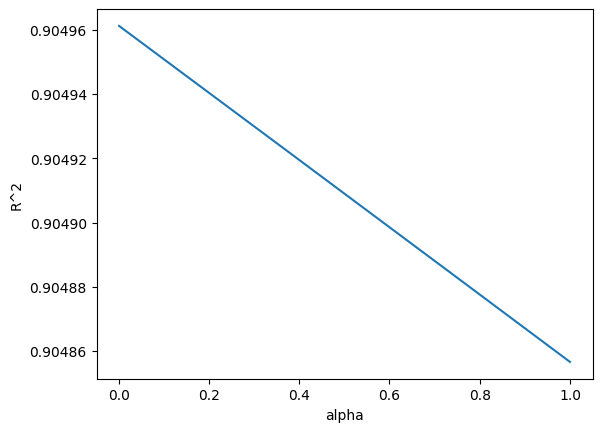

Max R^2 = 0.9049612314074111
alpha for max R^2 =  0.001


In [ ]:
r2=[]
alpha=[]
for i in tqdm(range(1,1001)):
    model=Ridge(alpha=0.001*i)
    model.fit(X_train_poly, y_train)
    y_train_pred = model.predict(X_validate_poly)
    r2.append(model.score(X_validate_poly, y_validate))
    alpha.append(0.001*i)
plt.plot(alpha,r2)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.show()
print("Max R^2 =",max(r2))
print("alpha for max R^2 = ",alpha[r2.index(max(r2))])

100%|██████████| 10000/10000 [00:05<00:00, 1927.67it/s]


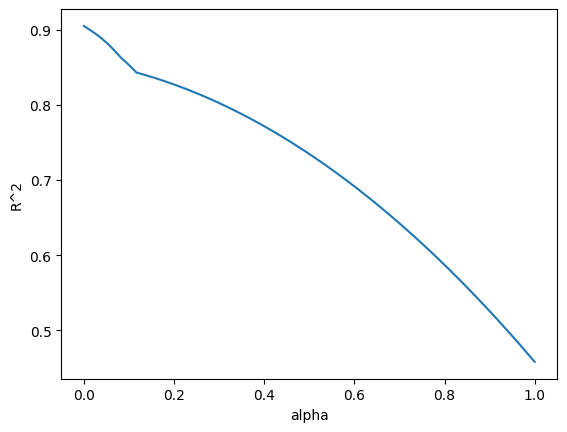

Max R^2 = 0.904924798401203
alpha for max R^2 =  0.0001


In [ ]:
r2=[]
alpha=[]
for i in tqdm(range(1,10001)):
    model=Lasso(alpha=0.0001*i)
    model.fit(X_train_poly, y_train)
    y_train_pred = model.predict(X_validate_poly)
    r2.append(model.score(X_validate_poly, y_validate))
    alpha.append(0.0001*i)
plt.plot(alpha,r2)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.show()
print("Max R^2 =",max(r2))
print("alpha for max R^2 = ",alpha[r2.index(max(r2))])

100%|██████████| 4/4 [00:00<00:00, 30.86it/s]


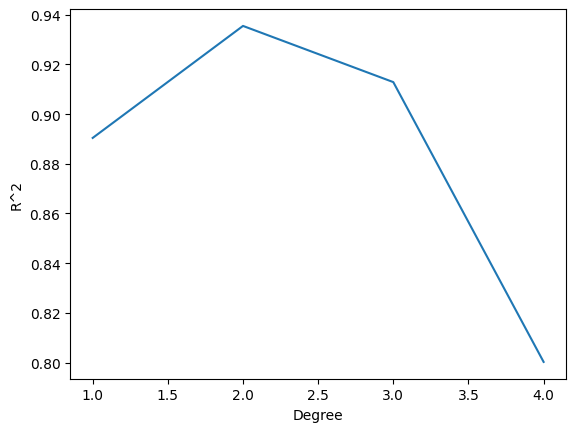

Max R^2 = 0.9355050133379623
Degree for max R^2 =  2


In [ ]:
r2=[]
deg=[]
for i in tqdm(range(1,5)):
    model=SVR(kernel='poly',degree=i)
    model.fit(X_train_poly, y_train)
    y_train_pred = model.predict(X_validate_poly)
    r2.append(model.score(X_validate_poly, y_validate))
    deg.append(i)
plt.plot(deg,r2)
plt.xlabel('Degree')
plt.ylabel('R^2')
plt.show()
print("Max R^2 =",max(r2))
print("Degree for max R^2 = ",deg[r2.index(max(r2))])

In [ ]:
test_df = pd.read_csv(test_file_path)

In [ ]:
y_test=test_df['PVOUT_csi (kWh/kWp)']
mean=y_test.mean()
std_dev=y_test.std()

In [ ]:
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(test_df)
scaled_df = pd.DataFrame(scaled_df, columns=test_df.columns)
scaled_df

,lat,long,PVOUT_csi (kWh/kWp),DNI (kWh/m2),GHI (kWh/m2),DIF (kWh/m2),GTI_opta (kWh/m2),OPTA (°),TEMP (°C),ELE (m)
0,-1.490660,0.424750,-0.876626,-0.359243,0.262329,0.410547,-0.264901,-1.417967,0.435677,-0.415317
1,1.089320,-1.444263,1.795923,1.147354,0.856457,0.527431,1.376914,0.843601,0.415513,-0.390772
2,1.577408,0.790278,-0.489475,-1.278141,-2.340534,-2.202798,-1.952942,1.723100,-2.447713,2.447378
3,-0.834007,1.108203,-0.770096,-0.604227,0.219332,0.799176,-0.208098,-1.041039,0.465922,-0.459271
4,-0.487540,-0.522791,-0.593032,-0.467930,0.019830,0.587928,-0.098547,-0.287183,0.365105,-0.454704
5,0.354922,-1.305985,1.299220,1.809834,0.798154,-0.656595,1.078005,0.341030,0.344941,-0.402188
6,-0.209444,0.949807,-0.365913,-0.247648,0.184431,0.534312,0.069570,-0.161541,0.420554,-0.325127


In [ ]:
test_data=scaled_df
X_test = test_data.drop(columns='PVOUT_csi (kWh/kWp)')
y_test = test_data['PVOUT_csi (kWh/kWp)']
reduced_features=pca.transform(X_test)
transformed_df=pd.DataFrame(reduced_features)
transformed_df

,0,1,2,3
0,-1.757381,0.695177,1.217790,-0.266382
1,-0.217163,-2.254164,-1.552740,0.780083
2,5.319234,2.143348,0.648352,-0.066141
3,-1.565045,1.119194,0.462340,-0.759658
4,-0.930437,0.309944,0.031861,0.698881
5,-0.057976,-2.564265,-0.539431,0.385650
6,-0.791232,0.550766,-0.268172,-0.772434


In [ ]:
model=LinearRegression()
reg=model.fit(X_train_poly, y_train)
y_test_pred = model.predict(poly.transform(reduced_features))

In [ ]:
results=pd.DataFrame(reduced_features)
results['PVOUT_csi (kWh/kWp)']=y_test_pred*std_dev+mean
results

,0,1,2,3,PVOUT_csi (kWh/kWp)
0,-1.757381,0.695177,1.217790,-0.266382,1577.247225
1,-0.217163,-2.254164,-1.552740,0.780083,1694.197542
2,5.319234,2.143348,0.648352,-0.066141,1522.862980
3,-1.565045,1.119194,0.462340,-0.759658,1564.965117
4,-0.930437,0.309944,0.031861,0.698881,1580.917153
5,-0.057976,-2.564265,-0.539431,0.385650,1715.159442
6,-0.791232,0.550766,-0.268172,-0.772434,1591.328464


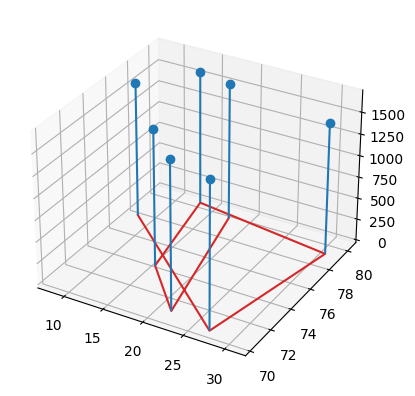

In [ ]:

x = np.array(test_df['lat'])
y =np.array(test_df['long'])
z =np.array(results['PVOUT_csi (kWh/kWp)'])

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(x, y, z)

plt.show()


In [ ]:
from geopy.geocoders import Nominatim
import folium
map=folium.Map()
loc=[]

geolocator = Nominatim(user_agent='myencoder', timeout=10)

test_size=len(test_df)

for i in range(test_size):
    lat=x[i]
    long=y[i]
    map.add_child(folium.Marker(location=[lat,long],popup=str(z[i]),icon=folium.Icon(color='green')))
    location = geolocator.geocode(str(lat)+","+str(long))
    loc.append(location)
map


GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=8.23549%2C77.550294&format=json&limit=1 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000214DA8AD250>: Failed to resolve 'nominatim.openstreetmap.org' ([Errno 11001] getaddrinfo failed)"))

In [ ]:
import numpy as np
import folium
from folium.plugins import HeatMap


x = x.reshape(test_size, 1)
y = y.reshape(test_size, 1)
z = (z.reshape(test_size, 1)-np.min(z))/(np.max(z)-np.min(z))

heat_data = np.block([[x, y, z]])

India_map = folium.Map(location=[20.5937, 78.9629], zoom_start=5)  
hm = HeatMap(heat_data.tolist())
hm.add_to(India_map)
India_map


In [ ]:
param=pd.read_excel('Test_params.xlsx')
param

,Area,Solar_cost,Wind_cost,Solar_Power,Wind_Power,lat,long
0,401,1.141326e+10,1.331306e+10,785.400514,569.477760,8.235490,77.550294
1,686,1.954698e+10,2.186692e+10,847.213463,1172.791598,27.231708,70.303710
2,735,2.208054e+10,2.544518e+10,761.244742,735.282807,30.825460,78.967529
3,487,1.375784e+10,1.627365e+10,787.282503,761.489126,13.070384,80.200195
4,869,2.274979e+10,2.711702e+10,784.068977,848.454601,15.621395,73.876465
5,679,1.857937e+10,2.218504e+10,856.071358,515.095283,21.824384,70.839844
6,966,2.734503e+10,3.168682e+10,794.626441,650.341881,17.668997,79.586060


In [ ]:
param['Solar_Power']=results['PVOUT_csi (kWh/kWp)']*0.5 #Commercial solar panel used with a rating of 0.5 kWp
param

,Area,Solar_cost,Wind_cost,Solar_Power,Wind_Power,lat,long
0,401,1.141326e+10,1.331306e+10,788.623612,569.477760,8.235490,77.550294
1,686,1.954698e+10,2.186692e+10,847.098771,1172.791598,27.231708,70.303710
2,735,2.208054e+10,2.544518e+10,761.431490,735.282807,30.825460,78.967529
3,487,1.375784e+10,1.627365e+10,782.482559,761.489126,13.070384,80.200195
4,869,2.274979e+10,2.711702e+10,790.458577,848.454601,15.621395,73.876465
5,679,1.857937e+10,2.218504e+10,857.579721,515.095283,21.824384,70.839844
6,966,2.734503e+10,3.168682e+10,795.664232,650.341881,17.668997,79.586060


In [ ]:
param.to_excel('Test_params.xlsx',index=False)

In [ ]:
k=test_df.drop(columns=['PVOUT_csi (kWh/kWp)'])
k.std()

lat                     7.952874
long                    4.187883
DNI (kWh/m2)          211.802201
GHI (kWh/m2)          190.762097
DIF (kWh/m2)           94.431781
GTI_opta (kWh/m2)     191.490461
OPTA (°)                8.596788
TEMP (°C)              13.392019
ELE (m)              1892.209278
dtype: float64